In [1]:
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.layers import Normalization
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, Flatten
from keras import layers
pd.set_option('display.max_rows', 50)
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping 

import random


2021-09-01 09:09:32.743627: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-09-01 09:09:32.743686: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
df_merged = pd.read_csv("data_final_20210826_v3.csv")

In [3]:
df_merged = df_merged.iloc[406:]  #294 not bad also 357 not bad

In [4]:
df_merged = df_merged.replace(np.nan, 0)

In [5]:
df_merged["tweet_date"] = pd.to_datetime(df_merged["tweet_date"])

df_merged = df_merged.groupby([pd.Grouper(key='tweet_date',freq='D'), "party"]).agg({
#     "reply_count": "sum", 
    "retweet_count": "sum",
    "like_count": "sum",
#     "avg_len_of_tweet": "mean" ,
#     "avg_followers_count": "mean" ,
#     "avg_following_count": "mean" ,
    "avg_user_tweet_count" :"mean",
    "avg_ff_ratio" :"mean",
    "share_of_tweets" :"mean",
    "share_unique_users": "mean",
    "weighted_sentiment" : "mean",
    "share_of_positive_tweets": "mean",
    "share_of_negative_tweets" : "mean",
    "poll": "mean"}) 

In [6]:
df_real_true = df_merged.iloc[-7:]

In [7]:
df_real_true

retweet_count  like_count  avg_user_tweet_count  \
tweet_date party                                                     
2021-08-26 AFD            7848.0     48207.0          18991.635859   
           CDU           13120.0     98419.0          22336.432628   
           FDP            3199.0     29066.0          17960.210457   
           GRUENE         9063.0     63348.0          20607.243817   
           LINKE           713.0      5282.0          20400.862207   
           OTHER          2166.0     11618.0          14171.402579   
           SPD           10807.0     89094.0          25279.190893   

                   avg_ff_ratio  share_of_tweets  share_unique_users  \
tweet_date party                                                       
2021-08-26 AFD         2.629856         0.157708            0.623978   
           CDU         4.669491         0.225380            0.646945   
           FDP         5.051935         0.110768            0.716828   
           GRUENE      6.755195         0.193819            0.638167   
           LINKE       1.407351         0.036379            0.590635   
           OTHER       2.100457         0.050955            0.579752   
           SPD         7.011461         0.224991            0.617673   

                   weighted_sentiment  share_of_positive_tweets  \
tweet_date party                                                  
2021-08-26 AFD              -0.830083                  0.047061   
           CDU              -0.370421                  0.042647   
           FDP              -0.577197                  0.056459   
           GRUENE           -0.149995                  0.062775   
           LINKE            -0.134164                  0.060201   
           OTHER            -0.129097                  0.087393   
           SPD              -0.255832                  0.073221   

                   share_of_negative_tweets  poll  
tweet_date party                                   
2021-08-26 AFD                     0.596667  11.0  
           CDU                     0.463291  23.0  
           FDP                     0.527460  12.0  
           GRUENE                  0.406026  18.0  
           LINKE                   0.400669   7.0  
           OTHER                   0.409742   6.0  
           SPD                     0.443543  23.0

In [8]:
df_merged = df_merged.iloc[:-7]

In [9]:
df_merged_final_test = df_merged.iloc[-14:]

In [10]:
df_merged_final = df_merged.iloc[:-7]

In [11]:
num_features = [ "retweet_count", "like_count", "avg_user_tweet_count","avg_ff_ratio"]
remaing_columns = ["share_of_tweets","share_unique_users","weighted_sentiment","share_of_positive_tweets","share_of_negative_tweets"]

In [12]:
from sklearn.preprocessing import MinMaxScaler

mm_scaler = MinMaxScaler()

mm_scaler.fit(df_merged_final[num_features])

numerical_train_scaled = mm_scaler.transform(df_merged_final[num_features])
numerical_test_scaled = mm_scaler.transform(df_merged_final_test[num_features])

In [13]:
df_merged_poll = df_merged_final["poll"] / 100
df_merged_poll_test = df_merged_final_test["poll"] / 100

In [14]:
df_numerical_train_scaled = pd.DataFrame(numerical_train_scaled, columns = num_features, index = df_merged_final.index)


In [15]:
df_train_scaled = pd.concat([df_numerical_train_scaled,df_merged_final[remaing_columns], pd.DataFrame(df_merged_poll, columns = ["poll"], index = df_merged_final.index)] , axis = 1)

In [16]:
df_test_scaled = pd.concat([pd.DataFrame(numerical_test_scaled, columns = num_features, index = df_merged_final_test.index),df_merged_final_test[remaing_columns], pd.DataFrame(df_merged_poll_test, columns = ["poll"], index = df_merged_final_test.index)] , axis = 1)

In [17]:
def subsequence(df, length, start = 0):
    last_possible_start = len(df) - length 
    X = df[start:start + length]
    y = df["poll"][(start + length ) : (start + length + 7)]
    
    return X, y

In [18]:
def multiple_subsequences(df, length):
    
    list_of_X = []
    list_of_y = []
    
    number_of_subsequences = round(len(df) /  7 - (length/7))
    print(number_of_subsequences)
    start = 0
    for num in range(number_of_subsequences):
        temporary_X, temporary_y = subsequence(df, length, start)
        list_of_X.append(temporary_X)
        list_of_y.append(temporary_y)
        start = start + 7
    
    return list_of_X, list_of_y

    
    
    

In [19]:
X_train , y_train = multiple_subsequences(pd.DataFrame(df_train_scaled), 28 )
# X_test , y_test = multiple_subsequences(df_test_scaled, 35)

29


In [20]:
(df_train_scaled.shape[0]/ 7)

33.0

In [21]:
X_train = np.array(X_train)
# X_test = np.array(X_test)
y_train = np.array(y_train)
# y_test = np.array(y_test)


In [23]:
model = Sequential()
# model.add(layers.Masking(mask_value=-9999, input_shape=X_train[0].shape))
model.add(layers.GRU(units=128, activation='tanh', return_sequences=True))
model.add(layers.GRU(units=64, activation='tanh', return_sequences=False))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(7, activation='linear'))


2021-09-01 09:09:40.570433: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-09-01 09:09:40.570508: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-09-01 09:09:40.570538: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (LAPTOP-69AIGBNI): /proc/driver/nvidia/version does not exist
2021-09-01 09:09:40.570903: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [24]:
%%time

es = EarlyStopping(patience = 3, restore_best_weights=True)


model.compile(loss='mse', optimizer='adam', metrics=['mae'])

history = model.fit(X_train, y_train ,
          epochs=40, 
          batch_size=1, 
          verbose=1, 
          validation_split=0.2,
          shuffle = False
     )



2021-09-01 09:09:40.804973: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/40
23/23 [==============================] - 3s 39ms/step - loss: 0.0038 - mae: 0.0426 - val_loss: 4.2166e-04 - val_mae: 0.0165
Epoch 2/40
23/23 [==============================] - 0s 15ms/step - loss: 4.8001e-04 - mae: 0.0178 - val_loss: 2.1840e-04 - val_mae: 0.0130
Epoch 3/40
23/23 [==============================] - 0s 15ms/step - loss: 4.9472e-04 - mae: 0.0173 - val_loss: 2.7491e-04 - val_mae: 0.0134
Epoch 4/40
23/23 [==============================] - 0s 17ms/step - loss: 2.7201e-04 - mae: 0.0127 - val_loss: 2.3358e-04 - val_mae: 0.0115
Epoch 5/40
23/23 [==============================] - 0s 16ms/step - loss: 2.1250e-04 - mae: 0.0112 - val_loss: 2.3003e-04 - val_mae: 0.0116
Epoch 6/40
23/23 [==============================] - 0s 16ms/step - loss: 2.0965e-04 - mae: 0.0111 - val_loss: 2.4282e-04 - val_mae: 0.0121
Epoch 7/40
23/23 [==============================] - 0s 16ms/step - loss: 2.0860e-04 - mae: 0.0111 - val_loss: 2.4229e-04 - val_mae: 0.0121
Epoch 8/40
23/23 [=============

In [25]:
df_test_scaled[7:]

retweet_count  like_count  avg_user_tweet_count  \
tweet_date party                                                     
2021-08-25 AFD          0.312997    0.240878              0.116577   
           CDU          0.357184    0.378131              0.206661   
           FDP          0.056263    0.071139              0.101904   
           GRUENE       0.330421    0.288473              0.178140   
           LINKE        0.035299    0.036964              0.403592   
           OTHER        0.046999    0.035793              0.047621   
           SPD          0.417790    0.290950              0.293910   

                   avg_ff_ratio  share_of_tweets  share_unique_users  \
tweet_date party                                                       
2021-08-25 AFD         0.150541         0.142871            0.610545   
           CDU         0.346532         0.259018            0.608679   
           FDP         0.337862         0.093089            0.715478   
           GRUENE      0.248616         0.236578            0.584365   
           LINKE       0.286147         0.046913            0.550127   
           OTHER       0.184260         0.046295            0.560913   
           SPD         0.537251         0.175236            0.662231   

                   weighted_sentiment  share_of_positive_tweets  \
tweet_date party                                                  
2021-08-25 AFD              -0.837779                  0.048682   
           CDU              -0.452031                  0.044395   
           FDP              -0.515992                  0.055877   
           GRUENE           -0.190728                  0.061242   
           LINKE            -0.059278                  0.050127   
           OTHER            -0.058430                  0.083082   
           SPD              -0.401099                  0.050722   

                   share_of_negative_tweets   poll  
tweet_date party                                    
2021-08-25 AFD                     0.600921  0.120  
           CDU                     0.484189  0.225  
           FDP                     0.513595  0.125  
           GRUENE                  0.418162  0.175  
           LINKE                   0.375956  0.070  
           OTHER                   0.385278  0.075  
           SPD                     0.475037  0.215

In [26]:
df_merged_final_day = np.array(df_test_scaled)
df_merged_final_day = np.expand_dims(df_merged_final_day, axis = 0)

In [27]:
df_prediction = pd.DataFrame(model.predict(df_merged_final_day)).rename( \
                        columns = {0:'AFD',1:'CDU',2:'FDP',3: 'GRUENE',4: 'LINKE', 5:'OTHER', 6: 'SPD'}).round(3)
df_prediction.index = ["pred"]

df_prediction

,AFD,CDU,FDP,GRUENE,LINKE,OTHER,SPD
pred,0.103,0.201,0.098,0.186,0.068,0.075,0.2


In [28]:
df_prediction_2 = pd.DataFrame((df_prediction.iloc[0]) / np.sum(df_prediction.iloc[0])).T
df_prediction_2 = df_prediction_2.round(4)

In [29]:
df_prediction_2

,AFD,CDU,FDP,GRUENE,LINKE,OTHER,SPD
pred,0.1106,0.2159,0.1053,0.1998,0.073,0.0806,0.2148


In [30]:
df_true = pd.DataFrame(df_real_true["poll"]).T/100

In [31]:
df_true = pd.DataFrame(df_true.iloc[0]).reset_index().groupby(by = "party").mean().T

In [32]:
df_true

party,AFD,CDU,FDP,GRUENE,LINKE,OTHER,SPD
poll,0.11,0.23,0.12,0.18,0.07,0.06,0.23


In [38]:
df_plotting_spd = df_train_scaled.reset_index().loc[df_train_scaled.reset_index()["party"] == "SPD"].drop(columns = "party")
df_plotting_cdu = df_train_scaled.reset_index().loc[df_train_scaled.reset_index()["party"] == "CDU"].drop(columns = "party")

<AxesSubplot:xlabel='tweet_date', ylabel='val'>

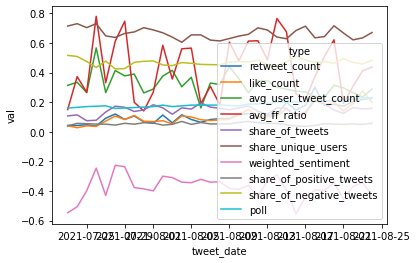

In [39]:
new_df = df_plotting_spd.melt(id_vars='tweet_date', 
                 value_name='val', 
                 var_name='type')

sns.lineplot(x='tweet_date', y='val', hue='type', data=new_df)

<AxesSubplot:xlabel='tweet_date', ylabel='val'>

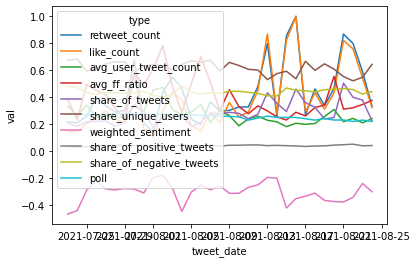

In [40]:
new_df = df_plotting_cdu.melt(id_vars='tweet_date', 
                 value_name='val', 
                 var_name='type')

sns.lineplot(x='tweet_date', y='val', hue='type', data=new_df)